In [10]:
# General imports
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

# Grizli
import grizli
from grizli.model import GrismFLT
import pysynphot as S

os.chdir("/Users/keith/astr/research_astr/summer-roman-project/4) FOV0_sims/fits")
root = "GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits" # Change filename with this variable
direct_file = "ready_direct_{0}".format(root)
seg_file = "seg_{0}".format(root)

In [11]:
# Identify objects of interest
tbl = Table.read("cat_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits.detect.cat", format="ascii.ecsv")

# Ensure you are using rotated coordinates
coords = (abs(tbl["x_flt"] - 4040) < 5) & (abs(tbl["y_flt"] - 3770) < 10)
index = np.where(coords)

# index = np.where(tbl['id']==7195)

tbl[index].pprint_all()

 id        x_flt             y_flt           mag_approx        segment_flux     mag  hlss_id      distance        z     MODIMAGE          SED           A_IMAGE B_IMAGE THETA_IMAGE
---- ----------------- ----------------- ------------------ ------------------ ----- ------- ----------------- -------- -------- ---------------------- ------- ------- -----------
7132 4036.515246784876 3765.933941026709 25.504703803788882 291.13191613554955 20.41  2678.0 2.060589700997127 1.464803        0 SED:rest:gal.2678.fits  1.7864  0.7212      340.84


In [12]:
# Instantiate the GrismFLT object
pad = 100
roman_sim = GrismFLT(direct_file=direct_file, seg_file=seg_file, pad=pad)

Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation seg_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...


In [13]:
# Read in SED
from astropy.io import fits
SED_dir = "/Users/keith/astr/research_astr/FOV0/FOV0_SEDs"
specific_sed = tbl["SED"][index].value[0]
print("SED Template:", specific_sed)

file = fits.open(os.path.join(SED_dir, specific_sed))
SED_data = file[1].data
file.close()

# Extract wavelength and flux
rest_wave = np.asarray([tuple[0] for tuple in SED_data])
z = tbl['z'][index]
redshifted_wave = rest_wave * (z+1)
del rest_wave

flux = np.asarray([tuple[1] for tuple in SED_data])

spec = S.ArraySpectrum(wave=redshifted_wave, flux=flux, fluxunits='flam')

df = Table.read("/Users/keith/astr/research_astr/FOV0/FOV0_SEDs/wfirst_wfi_f158_001_syn.fits", format='fits')
bp = S.ArrayBandpass(df["WAVELENGTH"], df["THROUGHPUT"])

SED Template: SED:rest:gal.2678.fits


In [14]:
id, mag = tbl['id'][index].value[0], tbl['mag'][index].value[0]

spec2 = spec.renorm(mag-3, 'abmag', bp)

In [15]:
# Compute Spectrum

print("Computing model order; id:{0} mag:{1}".format(id, mag))

roman_sim.compute_model_orders(id=id, mag=mag, compute_size=False, 
                               size=77, in_place=True, spectrum_1d=[spec2.wave, spec2.flux])
model_orders_3 = np.rot90(roman_sim.model[pad:-pad, pad:-pad])

Computing model order; id:7132 mag:20.41


In [8]:
# load in wang et al
file = fits.open("/Users/keith/astr/research_astr/FOV0/slitless/GRS_FOV0_roll0_dx0_dy0_SCA1_slitless_final.fits")
data = file[1].data
file.close()

(3000.0, 4088.0)

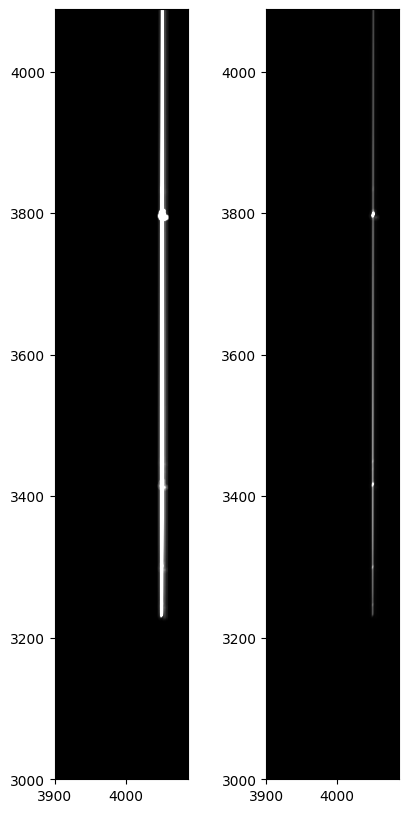

In [22]:
diff = model_orders_3 - model_orders


fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(5,10))

ax2.imshow(model_orders_3, origin="lower", cmap='grey', vmax=100)
ax2.set_xlim(3900, 4088)
ax2.set_ylim(3000,4088)

ax3.imshow(model_orders, origin="lower", cmap='grey', vmax=100)
ax3.set_xlim(3900, 4088)
ax3.set_ylim(3000,4088)

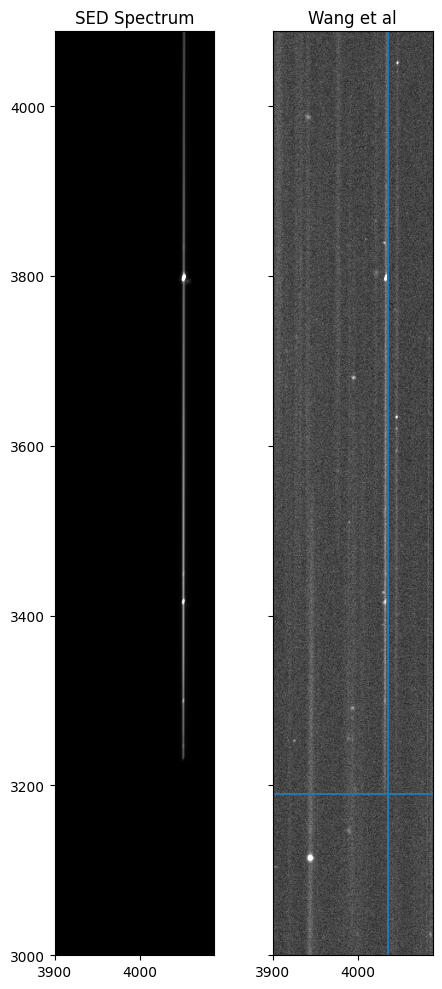

In [9]:
# Display comparison image
fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(5,10))

ax2.imshow(model_orders, origin="lower", cmap='grey', vmax=100)
ax2.set_xlim(3900, 4088)
ax2.set_ylim(3000,4088)
ax2.set_title("SED Spectrum")

ax3.imshow(data, origin="lower", cmap='grey', vmax=np.max(data)/100)
ax3.set_xlim(3900, 4088)
ax3.set_ylim(3000,4088)
ax3.set_title("Wang et al")
ax3.set_yticklabels([])

# ax2.axvline(4052)
ax3.axvline(4035)

ax3.axhline(3190)

fig.tight_layout()

In [8]:
# Assume they're off by a scalar
data_max = np.argmax(data[200:400, 2500:4000])
model_max = np.argmax(model_orders[200:400, 2500:4000])

scalar = np.max(data[200:400, 2500:4000]) / np.max(model_orders[200:400, 2500:4000])
print(scalar)

inf


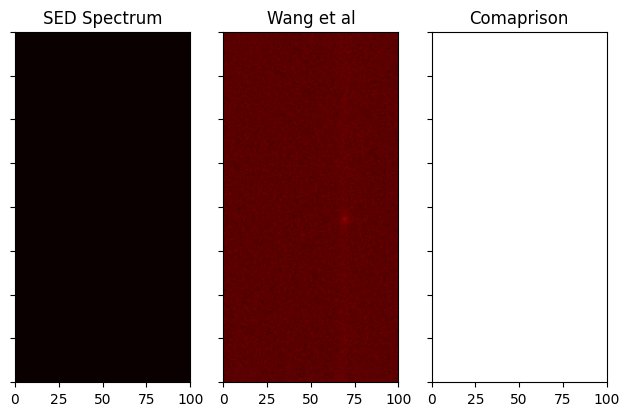

In [9]:
scaled_model = model_orders * scalar

# Display comparison image
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.imshow(model_orders, origin="lower", cmap='hot', vmax=np.max(model_orders)/5)
ax1.set_xlim(0, 100)
ax1.set_ylim(0, 200)
ax1.set_title("SED Spectrum")
ax1.set_yticklabels([])

ax2.imshow(data, origin="lower", cmap='hot', vmin=0, vmax=np.max(data)/25)
ax2.set_xlim(0, 100)
ax2.set_ylim(0, 200)
ax2.set_title("Wang et al")
ax2.set_yticklabels([])

ax3.imshow(data-scaled_model, origin="lower", cmap='hot', vmin=-np.max(scaled_model), vmax=np.max(data)/25)
ax3.set_xlim(0, 100)
ax3.set_ylim(0, 200)
ax3.set_title("Comaprison")
ax3.set_yticklabels([])

fig.tight_layout()

In [10]:
raise Exception("pause before saving")

Exception: pause before saving

In [ ]:
fits.writeto("single_object.fits", data = model_orders)